In [ ]:
pip install imblearn

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter1/framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
heart = pd.read_csv(file_content_stream)
heart = heart.dropna()
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Classification on Inbalanced Data

In [2]:
## frequency table of target 
heart['TenYearCHD'].value_counts() / heart.shape[0]

0    0.847648
1    0.152352
Name: TenYearCHD, dtype: float64

In [4]:
## Defining input and target variables
X = heart[['age',  'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']]
Y = heart['TenYearCHD']

## Splitting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a random forest model 
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       620
           1       1.00      0.01      0.02       112

    accuracy                           0.85       732
   macro avg       0.92      0.50      0.47       732
weighted avg       0.87      0.85      0.78       732



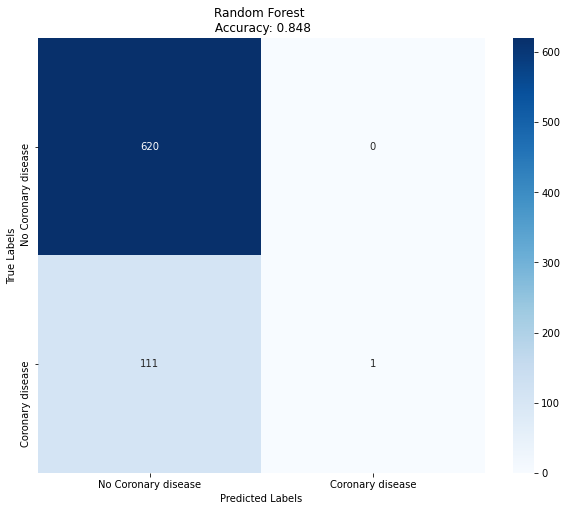

In [5]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot1.pdf')
plt.show()

## Alternate Cutoffs

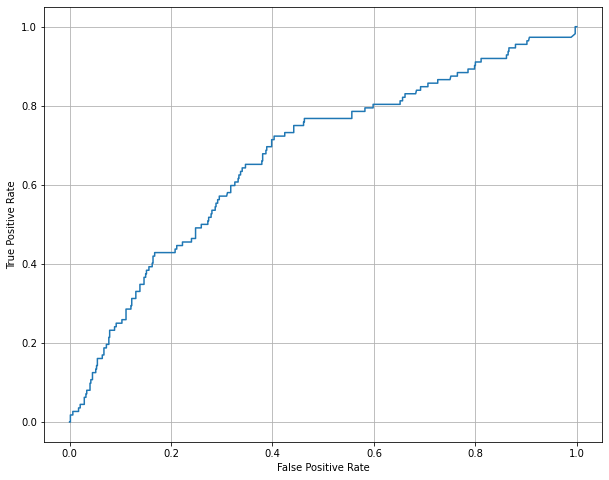

In [6]:
## Building a random forest model
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict_proba(X_test)[:, 1]

## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred)

## Visualizing the ROC-curve
plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
# plt.savefig('chapter1_plot2.pdf')
plt.show()

## Estimating cutoff based on shortest distance to perfect model 

In [7]:
cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model')
cutoff_values

,False_Positive,True_Positive,Cutoff,True_Positive_minus_1,Distance_to_perfect_model
122,0.403226,0.723214,0.148245,-0.276786,0.489082
120,0.398387,0.714286,0.148746,-0.285714,0.490250
110,0.346774,0.651786,0.159543,-0.348214,0.491432
123,0.406452,0.723214,0.148159,-0.276786,0.491745
118,0.388710,0.696429,0.151971,-0.303571,0.493205
...,...,...,...,...,...
222,0.996774,1.000000,0.071039,0.000000,0.996774
221,0.996774,0.982143,0.071525,-0.017857,0.996934
0,0.000000,0.000000,1.504256,-1.000000,1.000000
223,1.000000,1.000000,0.070394,0.000000,1.000000


In [8]:
## Predicting on the test dataset (using optimal cutoff)
RF_pred = np.where(RF_pred < 0.148, 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.92      0.59      0.72       620
           1       0.24      0.72      0.36       112

    accuracy                           0.61       732
   macro avg       0.58      0.66      0.54       732
weighted avg       0.82      0.61      0.67       732



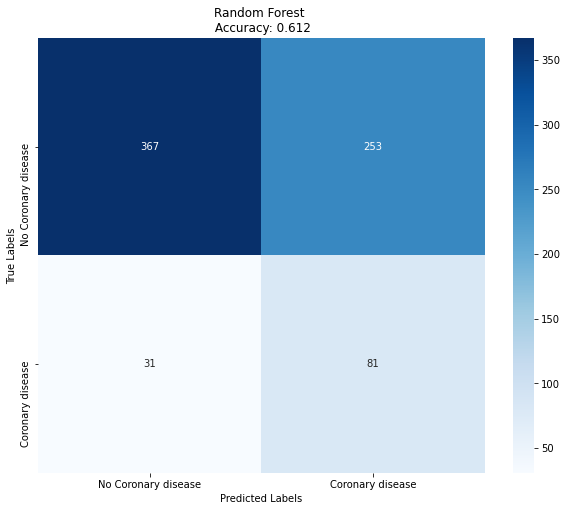

In [9]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot3.pdf')
plt.show()

## Estimating Cutoff Based on Younden's Index

In [10]:
cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['TPR_minus_FPR'] = cutoff_values['True_Positive'] - cutoff_values['False_Positive']

## Sorting based on TPR minus FPR
cutoff_values = cutoff_values.sort_values(by = 'TPR_minus_FPR', ascending = False)
cutoff_values

,False_Positive,True_Positive,Cutoff,TPR_minus_FPR
122,0.403226,0.723214,0.148245,0.319988
123,0.406452,0.723214,0.148159,0.316763
120,0.398387,0.714286,0.148746,0.315899
121,0.403226,0.714286,0.148398,0.311060
127,0.441935,0.750000,0.142048,0.308065
...,...,...,...,...
223,1.000000,1.000000,0.070394,0.000000
1,0.001613,0.000000,0.504256,-0.001613
219,0.980645,0.973214,0.071875,-0.007431
221,0.996774,0.982143,0.071525,-0.014631


## Dealing with Class-Imbalanced Data: Class Weights

In [11]:
## Building a random forest model (including weights)
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3, class_weight = 'balanced').fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict_proba(X_test)[:, 1]

In [12]:
## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred)

cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model')
cutoff_values

,False_Positive,True_Positive,Cutoff,True_Positive_minus_1,Distance_to_perfect_model
122,0.380645,0.732143,0.491335,-0.267857,0.465444
118,0.362903,0.705357,0.501513,-0.294643,0.467454
124,0.390323,0.741071,0.489667,-0.258929,0.468397
120,0.377419,0.714286,0.492646,-0.285714,0.473369
123,0.390323,0.732143,0.489722,-0.267857,0.473391
...,...,...,...,...,...
2,0.001613,0.008929,0.764947,-0.991071,0.991073
3,0.003226,0.008929,0.748723,-0.991071,0.991077
0,0.000000,0.000000,1.767953,-1.000000,1.000000
177,1.000000,1.000000,0.208420,0.000000,1.000000


In [13]:
## Changing likelihoods to labels (cutoff = 0.491)
RF_pred = np.where(RF_pred < 0.491, 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74       620
           1       0.26      0.73      0.38       112

    accuracy                           0.64       732
   macro avg       0.59      0.67      0.56       732
weighted avg       0.82      0.64      0.69       732



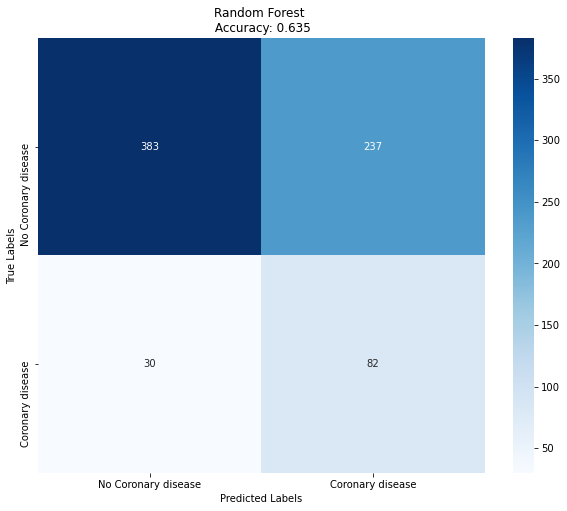

In [14]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot4.pdf')
plt.show()

## Under-Sampling

In [25]:
## Running under-sampling 
X_under, Y_under = RandomUnderSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_under = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_under, Y_under)

## Predicting on the test dataset
RF_pred_under = RF_under.predict_proba(X_test)[:, 1]

## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred_under)

cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model').reset_index(drop = True)

## Changing likelihoods to labels
RF_pred_under = np.where(RF_pred_under < cutoff_values['Cutoff'][0], 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_under))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       620
           1       0.25      0.74      0.37       112

    accuracy                           0.61       732
   macro avg       0.59      0.66      0.54       732
weighted avg       0.82      0.61      0.67       732



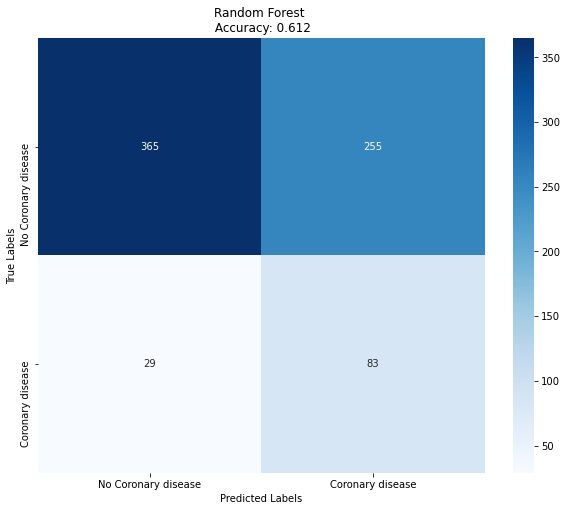

In [27]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_under)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_under)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot5.pdf')
plt.show()

## Over-Sampling

In [28]:
## Running over-sampling 
X_over, Y_over = RandomOverSampler().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_over = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_over, Y_over)

## Predicting on the test dataset
RF_pred_over = RF_over.predict_proba(X_test)[:, 1]

## Computing the ROC-curve
fpr, tpr, thresholds = roc_curve(Y_test, RF_pred_over)

cutoff_values = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'Cutoff': thresholds})
cutoff_values['True_Positive_minus_1'] = cutoff_values['True_Positive'] - 1
cutoff_values['Distance_to_perfect_model'] = np.sqrt(cutoff_values['False_Positive']**2 + cutoff_values['True_Positive_minus_1']**2)

## Sorting based on the distance to perfect model 
cutoff_values = cutoff_values.sort_values(by = 'Distance_to_perfect_model').reset_index(drop = True)

## Changing likelihoods to labels
RF_pred_over = np.where(RF_pred_over < cutoff_values['Cutoff'][0], 0, 1)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_over))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       620
           1       0.27      0.63      0.38       112

    accuracy                           0.69       732
   macro avg       0.59      0.67      0.59       732
weighted avg       0.82      0.69      0.73       732



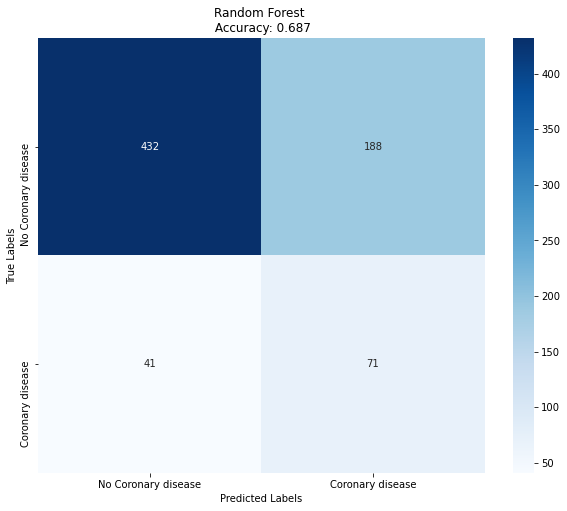

In [30]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_over)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_over)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot6.pdf')
plt.show()

## SMOTE

In [ ]:
## Running SMOTE
X_smote, Y_smote = SMOTE().fit_resample(X_train, Y_train)

## Building the random forest model 
RF_smote = RandomForestClassifier(n_estimators = 100, max_depth = 3).fit(X_smote, Y_smote)

## Predicting on the test dataset
RF_pred_smote = RF_over.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred_smote))

In [ ]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred_smote)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred_smote)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot5.pdf')
plt.show()

In [ ]:
## Building a random forest model (including weights)
RF_md = RandomForestClassifier(n_estimators = 100, max_depth = 3, class_weight = 'balanced').fit(X_train, Y_train)

## Predicting on the test dataset
RF_pred = RF_md.predict(X_test)

## Printing the classification report 
print(classification_report(Y_test, RF_pred))

In [ ]:
## Visualizing the confustion matrix
conf_mat = confusion_matrix(Y_test, RF_pred)
conf_mat_df = pd.DataFrame(conf_mat, index = ['No Coronary disease', 'Coronary disease'], columns = ['No Coronary disease', 'Coronary disease'])

plt.figure(figsize = (10, 8))
sns.heatmap(conf_mat_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Random Forest \n Accuracy:{0: .3f}'.format(accuracy_score(Y_test, RF_pred)))
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
# plt.savefig('chapter1_plot2.pdf')
plt.show()